In [1]:
from calendar import month
from itertools import count
from random import random

from IPython.core.completerlib import import_re
from zmq import METADATA

from extractors import Extractor
from csvmerger import CSVMerger
from pathlib import Path
import polars as pl
from random import random
import seaborn as sns

# Extract tar file

In [2]:
DATA_DIR = 'data'
FILE_NAME = 'imputed_goiener_v7.tar.zst'
EXTRACTED_DIR = Path(DATA_DIR, FILE_NAME.split('.')[0]) # imputed_goiener_v7

METADATA = Path(DATA_DIR, 'metadata.csv')

In [3]:
if not EXTRACTED_DIR.exists():
    extractor = Extractor(Path(DATA_DIR, FILE_NAME), DATA_DIR)

    extractor.decompress_tzst()

# Metadata normalization

In [4]:
metadata = pl.read_csv(METADATA, try_parse_dates=True, schema_overrides={'cnae':pl.String, 'codigo_postal':pl.String, 'fecha_alta':pl.String, 'fecha_baja':pl.String, 'p1_kw':pl.String, 'p2_kw':pl.String, 'p3_kw':pl.String, 'p4_kw':pl.String, 'p5_kw':pl.String, 'p6_kw':pl.String})
metadata

cups,fecha_alta,fecha_baja,p1_kw,p2_kw,p3_kw,codigo_postal,cnae,tarifa_atr,p4_kw,p5_kw,p6_kw
str,str,str,str,str,str,str,str,str,str,str,str
"""bd2b4dc5f0736640d40f6a88ce0db7…","""2017-06-24""","""NA""","""4.4""","""NA""","""NA""","""48993""","""9820""","""NA""","""NA""","""NA""","""NA"""
"""68acb4e01f277604d8729ecd4e4449…","""2017-11-01""","""NA""","""3.45""","""NA""","""NA""","""48300""","""9820""","""NA""","""NA""","""NA""","""NA"""
"""3d9675cee4194df1bed1afee12c257…","""2017-12-29""","""NA""","""3.45""","""NA""","""NA""","""31191""","""9820""","""NA""","""NA""","""NA""","""NA"""
"""e699f5789248530ba2ceab04b9da04…","""2017-09-13""","""NA""","""5.75""","""NA""","""5.75""","""20018""","""9820""","""NA""","""NA""","""NA""","""NA"""
"""80d96612acc08c3766d51bd94aeccf…","""2017-06-29""","""NA""","""4.4""","""NA""","""NA""","""48007""","""9820""","""NA""","""NA""","""NA""","""NA"""
…,…,…,…,…,…,…,…,…,…,…,…
"""899dda294b0dfab08e786eaccd63f2…","""2021-06-01""","""NA""","""3.45""","""3.45""","""NA""","""21200""","""9820""","""2.0TD""","""NA""","""NA""","""NA"""
"""f275f372d4bb766f56a6529c77dcb1…","""2021-06-01""","""2022-05-02""","""4.6""","""4.6""","""NA""","""42150""","""9820""","""2.0TD""","""NA""","""NA""","""NA"""
"""428398a84ce0522ea028cdeb93cf52…","""2021-07-02""","""2022-05-04""","""4.6""","""4.6""","""NA""","""42002""","""9821""","""2.0TD""","""NA""","""NA""","""NA"""


In [5]:
metadata_normalized = metadata.with_columns(
    pl.col("cups").alias("id"),
    pl.when(pl.col("fecha_alta").str.contains("/"))
      .then(
          pl.col("fecha_alta")
            .str.strptime(pl.Date, "%d/%m/%Y", strict=False)
            .dt.strftime("%Y-%m-%d")
      )
      .otherwise(
          pl.when(pl.col("fecha_alta").str.contains("-"))
            .then(pl.col("fecha_alta"))
            .otherwise(None)
      ).alias("start_date")
    .cast(pl.Date),
    pl.when(pl.col("fecha_baja").str.contains("/"))
      .then(
          pl.col("fecha_baja")
            .str.strptime(pl.Date, "%d/%m/%Y", strict=False)
            .dt.strftime("%Y-%m-%d")
      )
      .otherwise(
          pl.when(pl.col("fecha_baja").str.contains("-"))
            .then(pl.col("fecha_baja"))
            .otherwise(None)
      ).alias("end_date")
    .cast(pl.Date),
    pl.when(pl.col("p1_kw") == "NA")
      .then(pl.lit(None).cast(pl.Float64))
      .otherwise(pl.col("p1_kw").cast(pl.Float64, strict=False)).alias("p1_kw"),
    pl.when(pl.col("p2_kw") == "NA")
      .then(pl.lit(None).cast(pl.Float64))
      .otherwise(pl.col("p2_kw").cast(pl.Float64, strict=False)).alias("p2_kw"),
    pl.when(pl.col("p3_kw") == "NA")
      .then(pl.lit(None).cast(pl.Float64))
      .otherwise(pl.col("p3_kw").cast(pl.Float64, strict=False)).alias("p3_kw"),
    pl.when(pl.col("p4_kw") == "NA")
      .then(pl.lit(None).cast(pl.Float64))
      .otherwise(pl.col("p4_kw").cast(pl.Float64, strict=False)).alias("p4_kw"),
    pl.when(pl.col("p5_kw") == "NA")
      .then(pl.lit(None).cast(pl.Float64))
      .otherwise(pl.col("p5_kw").cast(pl.Float64, strict=False)).alias("p5_kw"),
    pl.when(pl.col("p6_kw") == "NA")
      .then(pl.lit(None).cast(pl.Float64))
      .otherwise(pl.col("p6_kw").cast(pl.Float64, strict=False)).alias("p6_kw"),

    pl.when(pl.col("codigo_postal") == "NA")
      .then(None)
      .otherwise(pl.col("codigo_postal").cast(pl.String, strict=False)).alias("postal_code"),
    pl.when(pl.col("cnae") == "NA")
      .then(None)
      .otherwise(pl.col("cnae").cast(pl.String, strict=False)).alias("cnae"),
    pl.when(pl.col("tarifa_atr") == "NA")
      .then(None)
      .otherwise(pl.col("tarifa_atr").cast(pl.String, strict=False)).alias("tarriff"),
).drop(["cups", "fecha_alta", "fecha_baja", "codigo_postal", "tarifa_atr"])

metadata_normalized = metadata_normalized.select([
    pl.col("id"),
    pl.col("start_date"),
    pl.col("end_date"),
    pl.col("cnae"),
    pl.col("postal_code"),
    pl.col("p1_kw"),
    pl.col("p2_kw"),
    pl.col("p3_kw"),
    pl.col("p4_kw"),
    pl.col("p5_kw"),
    pl.col("p6_kw"),
    pl.col("tarriff"),
])

metadata_normalized

id,start_date,end_date,cnae,postal_code,p1_kw,p2_kw,p3_kw,p4_kw,p5_kw,p6_kw,tarriff
str,date,date,str,str,f64,f64,f64,f64,f64,f64,str
"""bd2b4dc5f0736640d40f6a88ce0db7…",2017-06-24,null,"""9820""","""48993""",4.4,null,null,null,null,null,null
"""68acb4e01f277604d8729ecd4e4449…",2017-11-01,null,"""9820""","""48300""",3.45,null,null,null,null,null,null
"""3d9675cee4194df1bed1afee12c257…",2017-12-29,null,"""9820""","""31191""",3.45,null,null,null,null,null,null
"""e699f5789248530ba2ceab04b9da04…",2017-09-13,null,"""9820""","""20018""",5.75,null,5.75,null,null,null,null
"""80d96612acc08c3766d51bd94aeccf…",2017-06-29,null,"""9820""","""48007""",4.4,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…
"""899dda294b0dfab08e786eaccd63f2…",2021-06-01,null,"""9820""","""21200""",3.45,3.45,null,null,null,null,"""2.0TD"""
"""f275f372d4bb766f56a6529c77dcb1…",2021-06-01,2022-05-02,"""9820""","""42150""",4.6,4.6,null,null,null,null,"""2.0TD"""
"""428398a84ce0522ea028cdeb93cf52…",2021-07-02,2022-05-04,"""9821""","""42002""",4.6,4.6,null,null,null,null,"""2.0TD"""


In [6]:
metadata_normalized.write_csv('data/metadata_normalized.csv')

In [7]:
metadata_normalized = pl.read_csv('data/metadata_normalized.csv', try_parse_dates=True, schema_overrides={'cnae':pl.String, 'postal_code':pl.String, 'start_date':pl.Date, 'end_date':pl.Date, 'p1_kw':pl.Float64, 'p2_kw':pl.Float64, 'p3_kw':pl.Float64, 'p4_kw':pl.Float64, 'p5_kw':pl.Float64, 'p6_kw':pl.Float64})
metadata_normalized

id,start_date,end_date,cnae,postal_code,p1_kw,p2_kw,p3_kw,p4_kw,p5_kw,p6_kw,tarriff
str,date,date,str,str,f64,f64,f64,f64,f64,f64,str
"""bd2b4dc5f0736640d40f6a88ce0db7…",2017-06-24,null,"""9820""","""48993""",4.4,null,null,null,null,null,null
"""68acb4e01f277604d8729ecd4e4449…",2017-11-01,null,"""9820""","""48300""",3.45,null,null,null,null,null,null
"""3d9675cee4194df1bed1afee12c257…",2017-12-29,null,"""9820""","""31191""",3.45,null,null,null,null,null,null
"""e699f5789248530ba2ceab04b9da04…",2017-09-13,null,"""9820""","""20018""",5.75,null,5.75,null,null,null,null
"""80d96612acc08c3766d51bd94aeccf…",2017-06-29,null,"""9820""","""48007""",4.4,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…
"""899dda294b0dfab08e786eaccd63f2…",2021-06-01,null,"""9820""","""21200""",3.45,3.45,null,null,null,null,"""2.0TD"""
"""f275f372d4bb766f56a6529c77dcb1…",2021-06-01,2022-05-02,"""9820""","""42150""",4.6,4.6,null,null,null,null,"""2.0TD"""
"""428398a84ce0522ea028cdeb93cf52…",2021-07-02,2022-05-04,"""9821""","""42002""",4.6,4.6,null,null,null,null,"""2.0TD"""


# Analyze metadata

In [8]:
for col in metadata_normalized.columns:
    print(f"Column: {col}")
    print(metadata_normalized[col].value_counts().sort(by='count', descending=True).head(5))
    print("\n")

Column: id
shape: (5, 2)
┌─────────────────────────────────┬───────┐
│ id                              ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ 487142277b847778f21a26ef7aab3a… ┆ 98    │
│ c3100370ed75bcec6ca6cc0e1cdb78… ┆ 85    │
│ e7bfc6f420a4e7b0ca49fd43c79ecf… ┆ 73    │
│ c60501002d1d94f471d950e632d34b… ┆ 64    │
│ 928b4a983a66aef410f9c3afcc786c… ┆ 52    │
└─────────────────────────────────┴───────┘


Column: start_date
shape: (5, 2)
┌────────────┬───────┐
│ start_date ┆ count │
│ ---        ┆ ---   │
│ date       ┆ u32   │
╞════════════╪═══════╡
│ 2021-06-01 ┆ 92200 │
│ 2013-11-12 ┆ 784   │
│ 2021-08-01 ┆ 649   │
│ 2017-02-17 ┆ 619   │
│ 2020-10-01 ┆ 578   │
└────────────┴───────┘


Column: end_date
shape: (5, 2)
┌────────────┬────────┐
│ end_date   ┆ count  │
│ ---        ┆ ---    │
│ date       ┆ u32    │
╞════════════╪════════╡
│ null       ┆ 177845 │
│ 2021-05-31 ┆ 57060  │
│ 

In [9]:
metadata_pre_covid = metadata_normalized.filter([
    pl.col("start_date").is_between(pl.datetime(2000, 5, 31, time_zone="UTC"), pl.datetime(2020, 3, 1, time_zone="UTC")),
    pl.col("end_date").is_between(pl.datetime(2000, 5, 31, time_zone="UTC"), pl.datetime(2020, 3, 1, time_zone="UTC"))
])

metadata_post_covid = metadata_normalized.filter([
    pl.col("start_date").is_between(pl.datetime(2020, 5, 31, time_zone="UTC"), pl.datetime(3020, 3, 1, time_zone="UTC")),
    pl.col("end_date").is_between(pl.datetime(2020, 5, 31, time_zone="UTC"), pl.datetime(3020, 3, 1, time_zone="UTC"))
])

metadata_pre_covid.head()
metadata_post_covid.head()

id,start_date,end_date,cnae,postal_code,p1_kw,p2_kw,p3_kw,p4_kw,p5_kw,p6_kw,tarriff
str,date,date,str,str,f64,f64,f64,f64,f64,f64,str
"""487142277b847778f21a26ef7aab3a…",2020-08-28,2020-08-31,"""9321""","""31780""",24.0,24.0,24.0,null,null,null,null
"""8544377c293e5800de11002b792434…",2020-06-06,2020-10-06,"""8411""","""20600""",4.0,null,null,null,null,null,null
"""89513e3f453779bcd01f5873fe672f…",2020-08-28,2020-09-03,"""8411""","""31891""",2.2,null,null,null,null,null,null
"""8879dab7c8d758d88ca22b30e4e3e8…",2020-09-01,2020-09-15,"""9311""","""31382""",20.0,20.0,20.0,null,null,null,null
"""845fb52382859463b29bff03a76d36…",2020-09-01,2020-09-15,"""9820""","""31382""",15.1,15.1,15.1,null,null,null,null


In [10]:
metadata_post_covid_households = metadata_post_covid.filter(
    (pl.col('cnae') > '9699'),
    (pl.col('cnae') < '9900')
)
metadata_post_covid_households.write_csv('data/metadata_post_covid_households.csv')
metadata_post_covid_households

id,start_date,end_date,cnae,postal_code,p1_kw,p2_kw,p3_kw,p4_kw,p5_kw,p6_kw,tarriff
str,date,date,str,str,f64,f64,f64,f64,f64,f64,str
"""845fb52382859463b29bff03a76d36…",2020-09-01,2020-09-15,"""9820""","""31382""",15.1,15.1,15.1,null,null,null,null
"""401508960306fd7e9b6d006c08f3f5…",2020-07-09,2020-09-07,"""9820""","""20018""",3.3,null,null,null,null,null,null
"""04efc2fcc920894f60f3ef3ea303ae…",2020-06-09,2020-06-10,"""9820""","""20800""",2.0,null,null,null,null,null,null
"""8f1685c3ba864fe42243df84f80489…",2020-07-28,2020-07-28,"""9810""","""48130""",1.1,null,null,null,null,null,null
"""fc8be41318399e684800f7c074aa83…",2020-06-03,2020-08-31,"""9820""","""48006""",1.0,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…
"""644be161153608f1694861746ea2de…",2021-06-01,2022-04-24,"""9820""","""41120""",4.6,4.6,null,null,null,null,"""2.0TD"""
"""abeb05b9b0461b9be4313f6e6378c2…",2021-09-21,2022-04-25,"""9820""","""21200""",3.3,3.3,null,null,null,null,"""2.0TD"""
"""f275f372d4bb766f56a6529c77dcb1…",2021-06-01,2022-05-02,"""9820""","""42150""",4.6,4.6,null,null,null,null,"""2.0TD"""


# Analyze user data

In [11]:
metadata_post_covid_households = pl.read_csv('data/metadata_post_covid_households.csv', try_parse_dates=True, schema_overrides= {'cnae':pl.String, 'postal_code':pl.String, 'start_date':pl.Date, 'end_date':pl.Date, 'p1_kw':pl.Float64, 'p2_kw':pl.Float64, 'p3_kw':pl.Float64, 'p4_kw':pl.Float64, 'p5_kw':pl.Float64, 'p6_kw':pl.Float64})

metadata_post_covid_households.head()

id,start_date,end_date,cnae,postal_code,p1_kw,p2_kw,p3_kw,p4_kw,p5_kw,p6_kw,tarriff
str,date,date,str,str,f64,f64,f64,f64,f64,f64,str
"""845fb52382859463b29bff03a76d36…",2020-09-01,2020-09-15,"""9820""","""31382""",15.1,15.1,15.1,null,null,null,null
"""401508960306fd7e9b6d006c08f3f5…",2020-07-09,2020-09-07,"""9820""","""20018""",3.3,null,null,null,null,null,null
"""04efc2fcc920894f60f3ef3ea303ae…",2020-06-09,2020-06-10,"""9820""","""20800""",2.0,null,null,null,null,null,null
"""8f1685c3ba864fe42243df84f80489…",2020-07-28,2020-07-28,"""9810""","""48130""",1.1,null,null,null,null,null,null
"""fc8be41318399e684800f7c074aa83…",2020-06-03,2020-08-31,"""9820""","""48006""",1.0,null,null,null,null,null,null


In [12]:
households = metadata_post_covid_households['id'].unique().to_list()
print(f"Post-COVID households={len(households)}")

random_house = households[int(random() * len(households))]
print(f"Random household id: {random_house}")

Post-COVID households=8273
Random household id: f0d43fcc7e917ff4af615171d5452d636276d2abd6ca4a8e12ab08cbc93a54b1


In [13]:
random_house_df = pl.read_csv(EXTRACTED_DIR / f"{random_house}.csv", try_parse_dates=True, schema_overrides={'kWh':pl.Float64})
random_house_df

index,fl,kWh,imp
datetime[μs],i64,f64,i64
2021-05-13 00:00:00,1,0.0,0
2021-05-13 01:00:00,1,0.0,0
2021-05-13 02:00:00,1,0.0,0
2021-05-13 03:00:00,1,0.0,0
2021-05-13 04:00:00,1,0.0,0
…,…,…,…
2024-01-30 20:00:00,0,0.132,0
2024-01-30 21:00:00,0,0.708,0
2024-01-30 22:00:00,0,0.529,0


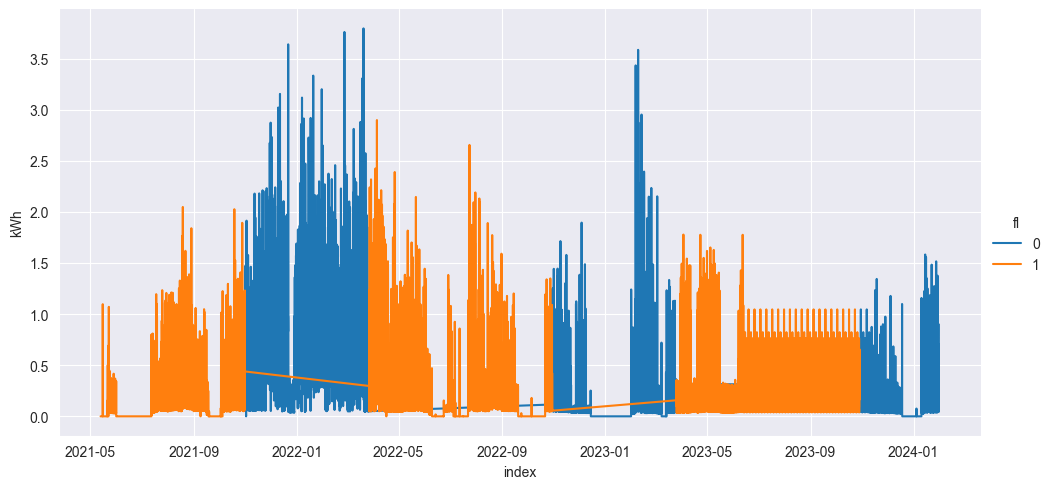

In [14]:
sns.relplot(random_house_df,x='index', y='kWh', kind="line", height=5, aspect=2, hue="fl")

# Combine CSV files

In [15]:
from csvmerger import CSVMerger
households_csvs = [f'{EXTRACTED_DIR}/{f}.csv' for f in households]

csvMerger = CSVMerger(households_csvs, None, 'data/household_kwh.csv')
csvMerger.combine_csv_files()

In [16]:
households_df = pl.read_csv('data/household_kwh.csv', try_parse_dates=True, schema_overrides={'kWh':pl.Float64}).with_columns(pl.col('index').alias('timestamp')).select('id', 'timestamp', 'kWh', 'imp')
households_df

id,timestamp,kWh,imp
str,datetime[μs],f64,i64
"""e35482a29c6c363e7130e487557bc3…",2019-06-28 00:00:00,0.315,0
"""e35482a29c6c363e7130e487557bc3…",2019-06-28 01:00:00,0.352,0
"""e35482a29c6c363e7130e487557bc3…",2019-06-28 02:00:00,0.39,0
"""e35482a29c6c363e7130e487557bc3…",2019-06-28 03:00:00,0.366,0
"""e35482a29c6c363e7130e487557bc3…",2019-06-28 04:00:00,0.275,0
…,…,…,…
"""050ff78435c53a93a9df287cf1fbde…",2022-07-06 19:00:00,0.802,0
"""050ff78435c53a93a9df287cf1fbde…",2022-07-06 20:00:00,0.498,0
"""050ff78435c53a93a9df287cf1fbde…",2022-07-06 21:00:00,0.283,0


In [40]:
for col in households_df.columns:
    print(f"Column: {col}")
    print(households_df[col].value_counts().sort(by='count', descending=True).head(5))
    print("\n")

Column: index
shape: (5, 2)
┌─────────────────────┬───────┐
│ index               ┆ count │
│ ---                 ┆ ---   │
│ datetime[μs]        ┆ u32   │
╞═════════════════════╪═══════╡
│ 2021-10-19 23:00:00 ┆ 6984  │
│ 2021-10-15 11:00:00 ┆ 6984  │
│ 2021-10-15 21:00:00 ┆ 6984  │
│ 2021-10-15 03:00:00 ┆ 6984  │
│ 2021-10-19 04:00:00 ┆ 6984  │
└─────────────────────┴───────┘


Column: fl
shape: (2, 2)
┌─────┬───────────┐
│ fl  ┆ count     │
│ --- ┆ ---       │
│ i64 ┆ u32       │
╞═════╪═══════════╡
│ 1   ┆ 145713087 │
│ 0   ┆ 101472339 │
└─────┴───────────┘


Column: kWh
shape: (5, 2)
┌───────┬──────────┐
│ kWh   ┆ count    │
│ ---   ┆ ---      │
│ f64   ┆ u32      │
╞═══════╪══════════╡
│ 0.0   ┆ 13071284 │
│ 0.052 ┆ 1301227  │
│ 0.05  ┆ 1299406  │
│ 0.048 ┆ 1298802  │
│ 0.054 ┆ 1296305  │
└───────┴──────────┘


Column: user_id
shape: (5, 2)
┌─────────────────────────────────┬───────┐
│ user_id                         ┆ count │
│ ---                             ┆ ---   │
│ str     

In [17]:
households_df

id,timestamp,kWh,imp
str,datetime[μs],f64,i64
"""61b8cbe5b2bd7763cd0d0fe8405eb1…",2020-07-24 00:00:00,0.0,0
"""61b8cbe5b2bd7763cd0d0fe8405eb1…",2020-07-24 01:00:00,0.0,0
"""61b8cbe5b2bd7763cd0d0fe8405eb1…",2020-07-24 02:00:00,0.0,0
"""61b8cbe5b2bd7763cd0d0fe8405eb1…",2020-07-24 03:00:00,0.0,0
"""61b8cbe5b2bd7763cd0d0fe8405eb1…",2020-07-24 04:00:00,0.0,0
…,…,…,…
"""4c18b5bca58cb4120e845e66ef159e…",2024-01-24 20:00:00,0.191,0
"""4c18b5bca58cb4120e845e66ef159e…",2024-01-24 21:00:00,0.214,0
"""4c18b5bca58cb4120e845e66ef159e…",2024-01-24 22:00:00,0.45,0
